## Final Project Submission

Please fill out:
* Student name: 
* Student pace: self paced / part time / full time
* Scheduled project review date/time: 
* Instructor name: 
* Blog post URL:


In [1]:
# my imports

# misc
import datetime
import os, shutil

# basics
import numpy as np
import pandas as pd


# charting
import matplotlib.pyplot as plt
%matplotlib inline 
from PIL import Image
import seaborn as sns

# keras
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG19
from keras import layers
from keras import models
from keras import optimizers


Using TensorFlow backend.


In [2]:
!ls

CONTRIBUTING.md                   data_organized
LICENSE.md                        index.ipynb
README.md                         input
aptos2019-blindness-detection.zip student.ipynb
brain.gif                         student_EDA_only.ipynb


In [3]:
# set file path variables
train_path = 'input/aptos2019-blindness-detection/train_images/'
test_path = 'input/aptos2019-blindness-detection/test_images/'

In [4]:
# load csv files with image file names and labels as pandas dataframes
train_data = pd.read_csv('input/aptos2019-blindness-detection/train.csv')
test_data = pd.read_csv('input/aptos2019-blindness-detection/test.csv')

In [5]:
train_data.head()

id_code  diagnosis
0  000c1434d8d7          2
1  001639a390f0          4
2  0024cdab0c1e          1
3  002c21358ce6          0
4  005b95c28852          0

In [6]:
test_data.head()

id_code
0  0005cfc8afb6
1  003f0afdcd15
2  006efc72b638
3  00836aaacf06
4  009245722fa4

In [7]:
# number of images in test & train data
print('Number of images in training set is {}'.format(len(train_data)))
print('Number of images in test set is {}'.format(len(test_data)))

Number of images in training set is 3662
Number of images in test set is 1928


In [8]:
class_dict = {0:'No DR', 1:'Mild DR', 2:'Moderate DR', 3:'Severe DR', 4:'Proliferative DR'}
class_labels = [0,1,2,3,4]
class_list = ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

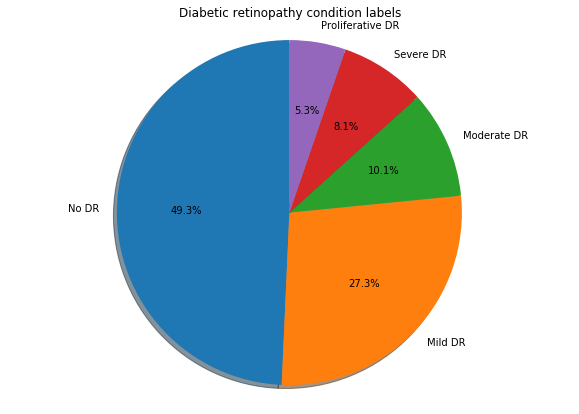

In [9]:
# Look at proportions of class members
sizes = train_data.diagnosis.value_counts()

fig1, ax1 = plt.subplots(figsize=(10,7))
ax1.pie(sizes, labels=class_list, autopct='%1.1f%%', shadow=True, startangle=90)
ax1.axis('equal')

plt.title('Diabetic retinopathy condition labels')
plt.show()

The data is very imbalanced. only 5.3% are severe cases, and nearly 50% show no evidence of the conditon. I will have to balance the data somehow.

In [10]:
# Balancing the data

In [11]:
# function to show some images

def show_15_images(df, category, test_train):
    # category is 0, 1, 2, 3, 4
    
    if test_train == "train":
        path = train_path
    elif test_train == "test":
        path = test_path
    else:
        print("specify test or train as third argument")
    rows = 3
    columns = 5
    fig, ax = plt.subplots(rows, columns, figsize=(15,10))
    
    title = class_list[category]
    images = df[df['diagnosis'] == category][:15].id_code.values
    
    for sample in range (0, 15):
        image = Image.open(os.path.join(path, images[sample] + '.png'))
        
        col = sample // columns
        row = sample % columns
        ax[col, row].imshow(image)
        ax[col, row].axis('off')
    
    plt.suptitle(title)
    plt.show()

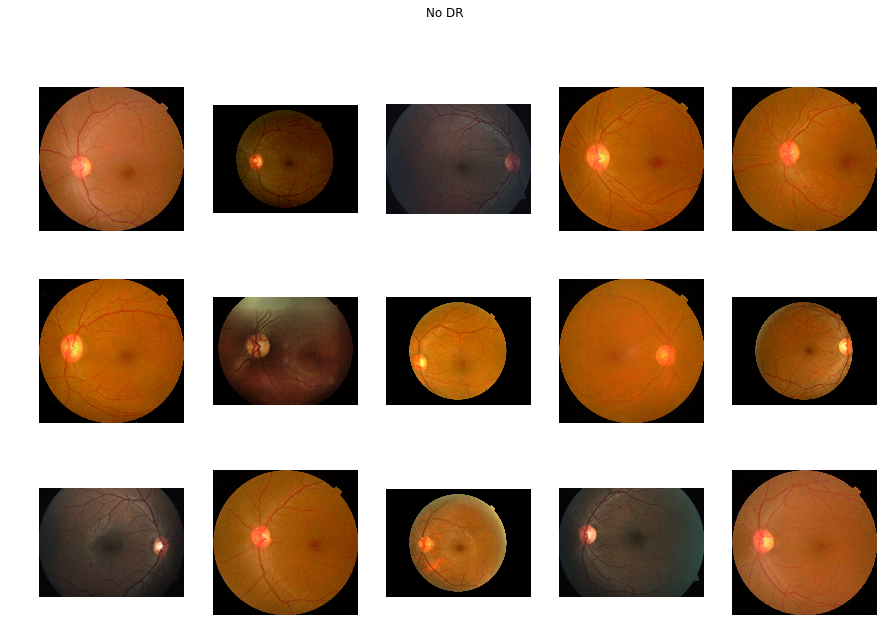

In [12]:
# look at some class 0 images in the training set
show_15_images(train_data, 0, 'train')

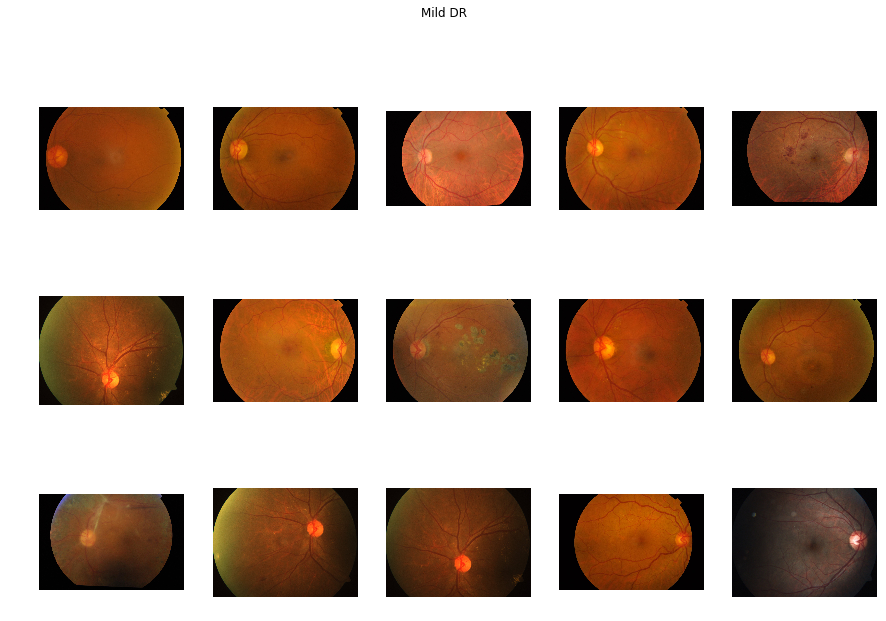

In [13]:
# look at some class 1 images
show_15_images(train_data, 1, 'train')

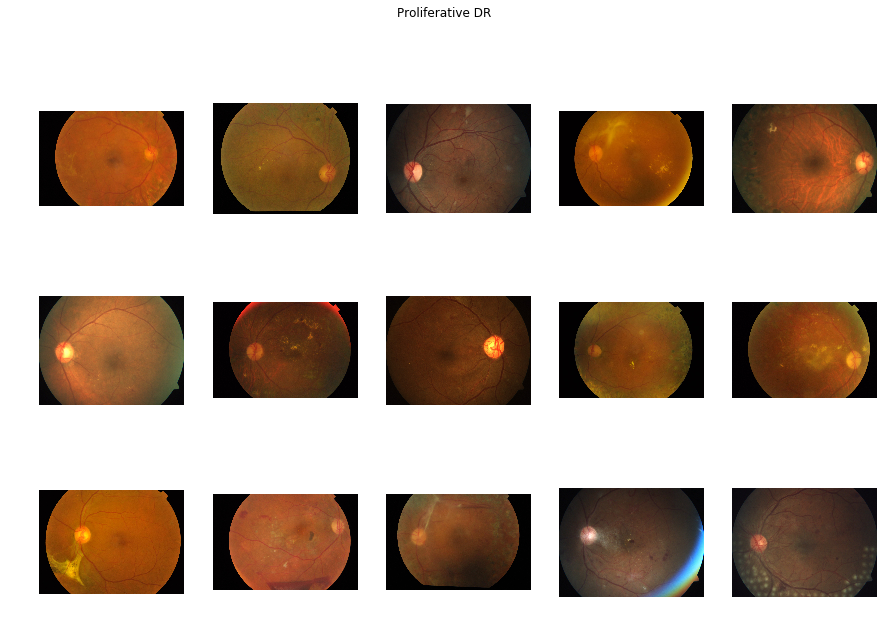

In [14]:
# look at some class 4 images
show_15_images(train_data, 4, 'train')

The images vary in dimensions, contrast, brightness, and orientation. I will need to adjust for this. 

In [15]:
# determine largest and smallest dimensions of the images
def get_dimensions(df, path):
    max_width = 0
    max_height = 0
    min_width = 0
    max_height = 0
    
    file_names = df['id_code']
    
    for index, file_name in enumerate(file_names):
        current_image = Image.open(os.path.join(path, file_name + '.png'))

        width, height = current_image.size
        
        # set initial values
        if max_width == 0:
            max_width = width
            min_width = width
            max_height = height
            min_height = height
        
        if width > max_width:
            max_width = width
        if width < min_width:
            min_width = width
            
        if height > max_height:
            max_height = height
        if height < min_height:
            min_height = height
            
    print('Minimum width: {},'.format(min_width))
    print('Maximum width: {},'.format(max_width))
    print('************')
    print('Minimum height: {}'.format(min_height))
    print('Maximum height: {}'.format(max_height))
    

In [16]:
get_dimensions(train_data, train_path)

Minimum width: 474,
Maximum width: 4288,
************
Minimum height: 358
Maximum height: 2848


In [17]:
# create a list of images with width between a range
def get_images_in_width_range(df, path, min_width, max_width): 
    small_images = []
    file_names = df['id_code']
    
    for index, file_name in enumerate(file_names):
        current_image = Image.open(os.path.join(path, file_name + '.png'))

        width, height = current_image.size
        
        if width >=  min_width:
            if width <= max_width:
                small_images.append(file_name)
    return small_images

In [18]:
small = get_images_in_width_range(train_data, train_path, 0, 800)

In [19]:
medium = get_images_in_width_range(train_data, train_path, 1200, 2000)

In [20]:
large = get_images_in_width_range(train_data, train_path, 3000, 3400 )

In [21]:
print('small: {}'.format(len(large)))
print('medium: {}'.format(len(medium)))
print('large: {}'.format(len(large)))

small: 551
medium: 169
large: 551


In [22]:
# https://pypi.org/project/pynput/
# !pip install pynput

In [23]:
# from pynput import keyboard

In [24]:
# function to look at a sample of images from a list of filenames
def show_images(ids, title, n_images):
    
    path = train_path
    rows = (n_images // 6) + 1
#     print (n_images % 6)
    if n_images % 6 == 0:
        rows = rows - 1
    columns = 6
    indexes = ids[0:(n_images)]
#     print(indexes)
    
    fig, ax = plt.subplots(rows, columns, figsize=(20,5))

    for index, file_name in enumerate(indexes):
        image = Image.open(os.path.join(path, str(file_name) + '.png'))
        
        col = index // columns
        row = index % columns
        ax[col, row].imshow(image)
        ax[col, row].axis('off')
    
    plt.suptitle(title)
    plt.show()

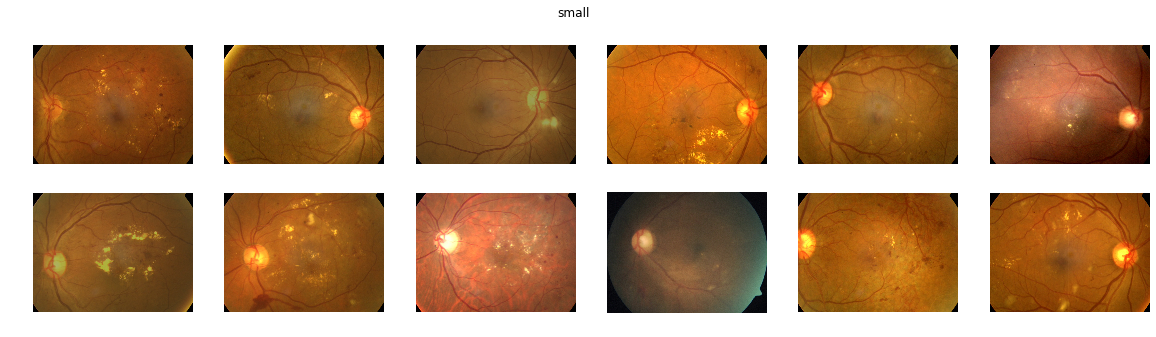

In [25]:
show_images(small, "small", 12)

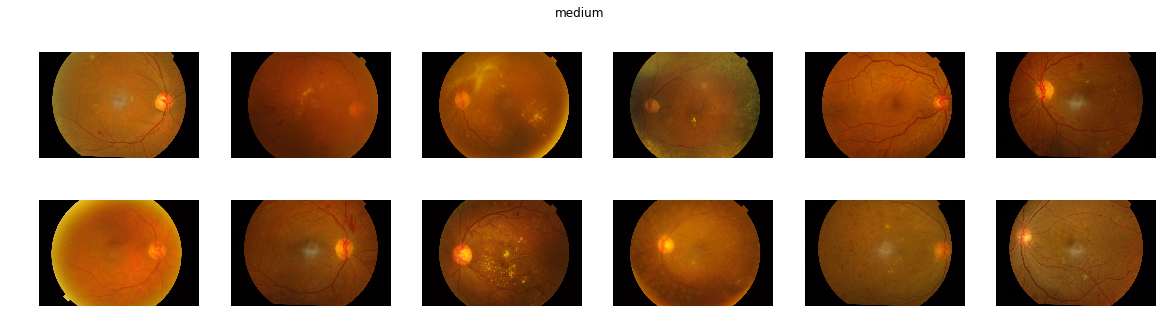

In [26]:
show_images(medium, "medium", 12)

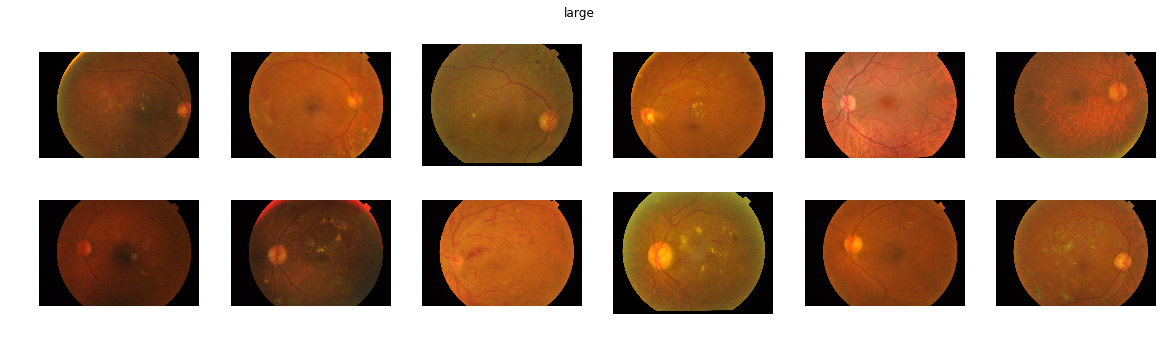

In [27]:
show_images(large, "large", 12)

In [28]:
# next step - look at a histogram of image sizes,
# also look at some sample images from different classes
# also look at the distribution of class by image size
# other things that could help me eliminate some of the class 0 images?


In [29]:
# show original image and cropped image

def show_image_crop(ids, title, n_images):

    path = train_path
    rows = (n_images // 6) + 1
    
    print('n_images: {}'.format(n_images))
    print('initial rows: {}'.format(rows))
    
    if n_images % 6 == 0:
        print('n_images % 6: {}'.format(n_images % 6))
        if n_images >= 6:
            rows = rows - 1
            print('new rows: {}'.format(rows))

    columns = 6

    indexes = ids[0:n_images]
    
    fig, ax = plt.subplots(rows, columns, figsize=(20,5))

    for index, file_name in enumerate(indexes):
        image = Image.open(os.path.join(path, str(file_name) + '.png'))
        
        row = index // columns
        col = index % columns
        
        ax[row, col].imshow(image)                
        ax[row, col].axis('off')

#         print('row: {}'.format(row))
#         print('col: {}'.format(col))

    plt.suptitle(title)
    plt.show()
    
    
    fig, ax = plt.subplots(rows, columns, figsize=(20,5))
    
    for index, file_name in enumerate(indexes):
        image = Image.open(os.path.join(path, str(file_name) + '.png'))
        width, height = image.size
        left = width * .2
        right = width * .8
        upper = 0
        lower = height
        image_crop = image.crop((left, upper, right, lower))
        
        row = index // columns
        col = index % columns
            
        ax[row, col].imshow(image_crop)                
        ax[row, col].axis('off')

    title = "cropped"
    plt.suptitle(title)
    plt.show()


    
# https://pillow.readthedocs.io/en/stable/reference/Image.html#PIL.Image.Image.crop
# Image.crop(box=None)[source]
# Returns a rectangular region from this image. 
# The box is a 4-tuple defining the left, upper, right, and lower pixel coordinate. See Coordinate System.

# Note: Prior to Pillow 3.4.0, this was a lazy operation.

# Parameters:	box – The crop rectangle, as a (left, upper, right, lower)-tuple.
# Return type:	Image
# Returns:	An Image object.

# The crop method from the Image module takes four coordinates as input.
# The right can also be represented as (left+width)
# and lower can be represented as (upper+height).
# (left, upper, right, lower) = (20, 20, 100, 100)

# Here the image "im" is cropped and assigned to new variable im_crop
# im_crop = im.crop((left, upper, right, lower))

    
# https://pillow.readthedocs.io/en/stable/handbook/concepts.html
# Coordinate System
# The Python Imaging Library uses a Cartesian pixel coordinate system, with (0,0) in the upper left corner. 
# Note that the coordinates refer to the implied pixel corners; 
# the centre of a pixel addressed as (0, 0) actually lies at (0.5, 0.5).

# Coordinates are usually passed to the library as 2-tuples (x, y). 
# Rectangles are represented as 4-tuples, with the upper left corner given first. 
# For example, a rectangle covering all of an 800x600 pixel image is written as (0, 0, 800, 600).  



n_images: 12
initial rows: 3
n_images % 6: 0
new rows: 2


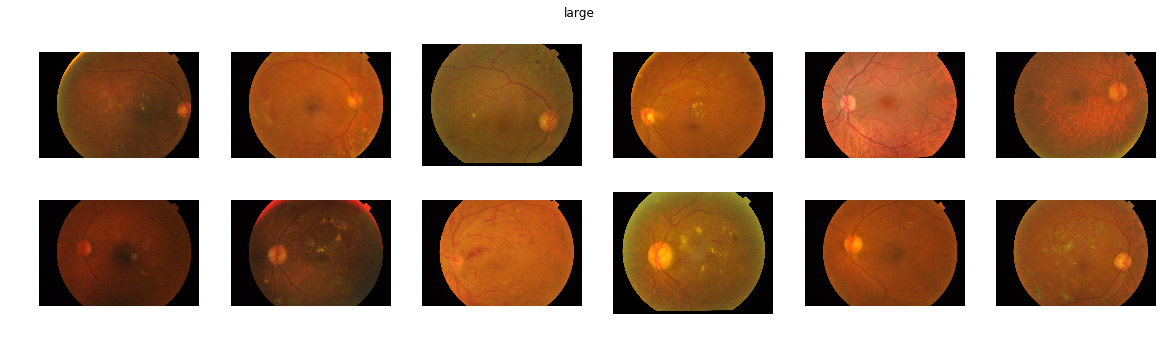

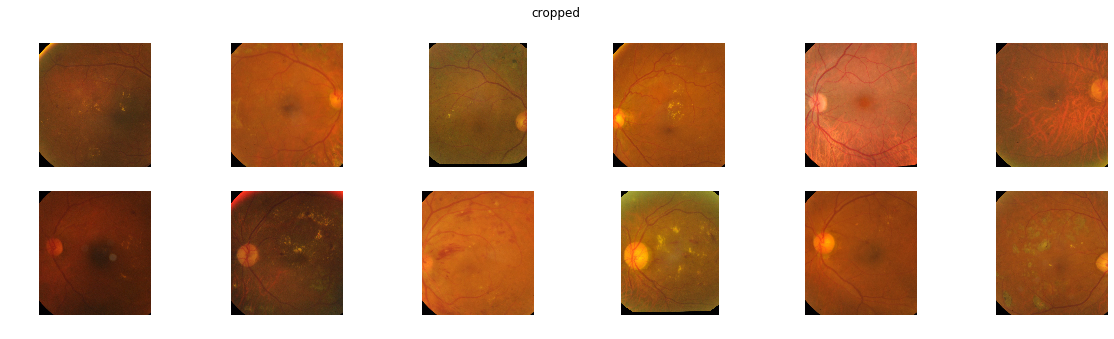

In [30]:
show_image_crop(large, "large", 12)


n_images: 12
initial rows: 3
n_images % 6: 0
new rows: 2


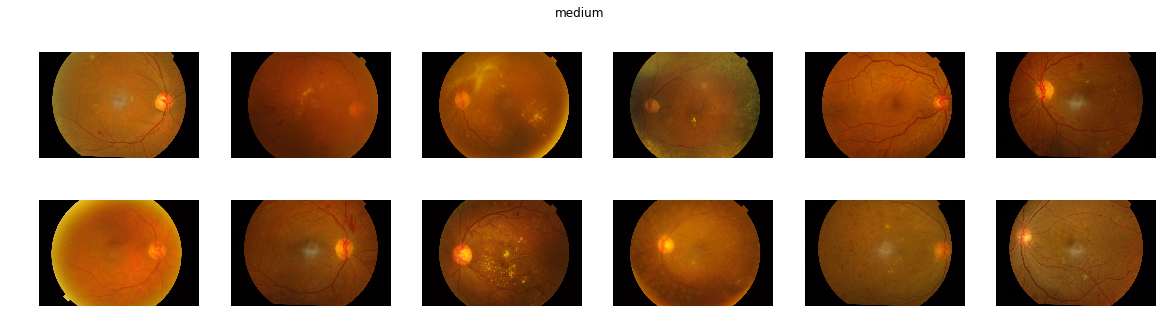

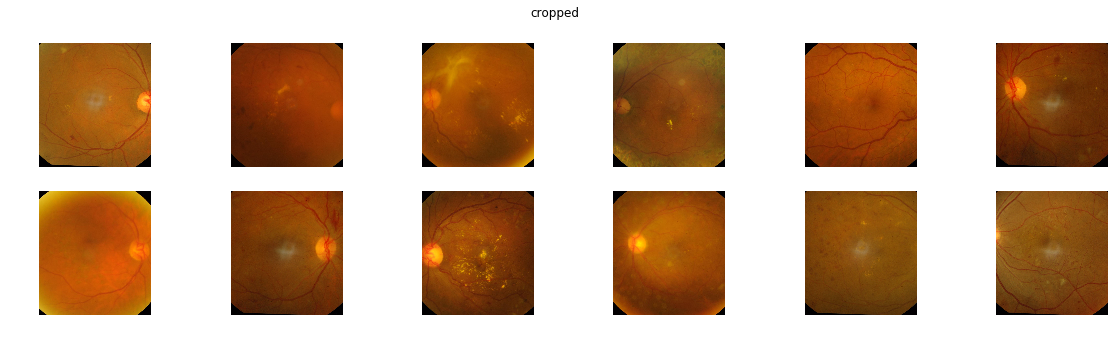

In [138]:
show_image_crop(medium, "medium", 12)

n_images: 12
initial rows: 3
n_images % 6: 0
new rows: 2


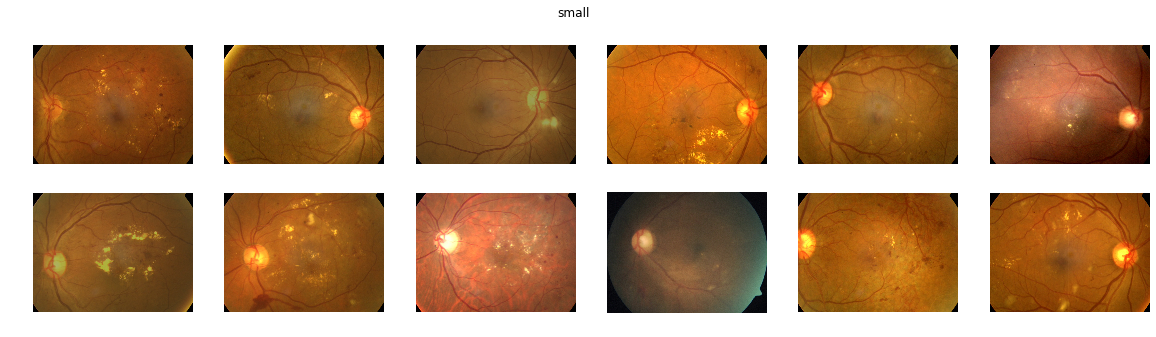

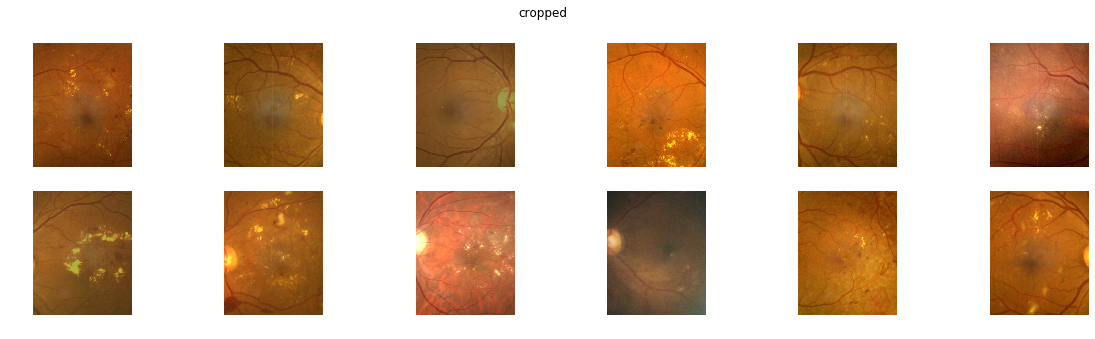

In [139]:
show_image_crop(small, "small", 12)

In [ ]:
# generate and save cropped and sized images
